# Konvoluční sítě

Na přednášce jste se bavili o konvolučních sítích, které si dnes se vyzkoušíme i na cvičení. Navíc si ukážeme i tensorboard a knihovnu pro vytváření matoucích vzorů.

Implementovat konvoluční síť v tensorflow je skoro stejné jako implementace jiných architektur. Než se dostaneme k samotným modelům, podíváme se na tři často používané datasety.  

In [6]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.datasets import cifar10, mnist,  fashion_mnist
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import linear, relu
from tensorflow.nn import softmax

import cleverhans.attacks

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

První z nich je datest MNIST, který obsahuje 60,000 trénovacích a 10,000 testovacích černobílých obrázků číslic 0-9, každý normalizovaný do velikosti 28x28 pixelů. Každá třída obsahuje stejný počet obrázků.

In [2]:
# funkce na zobrazeni obrazku
def show_dataset_examples(X, y, labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        idx = random.randint(0, X.shape[0]) 
        plt.subplot(5, 5, i+1)
        plt.imshow(X[idx])
        plt.title(labels[y[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

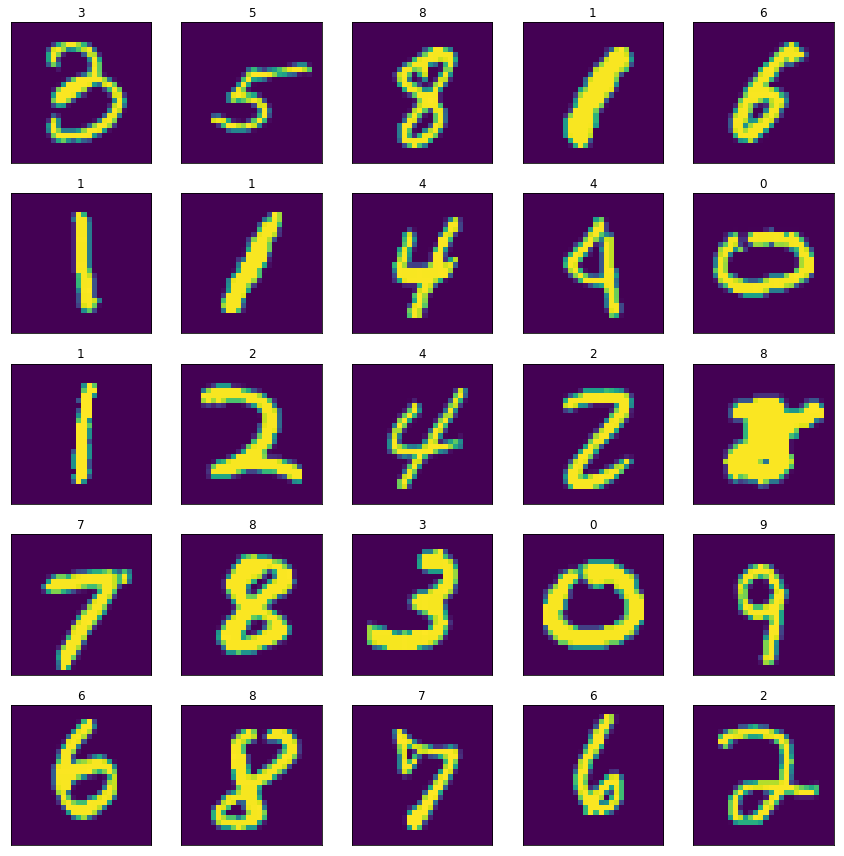

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
show_dataset_examples(x_train, y_train, mnist_class_labels)

Druhý je Fashion-MNIST, který se skládá z 60,000 trénovacích a 10,000 testovacích černobílých obrázků oblečení. Každý z nich je o rozměrech 28x28 pixelů a patří do jedné z 10 tříd: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot.

4423680/4422102 [==============================] - 1s 0us/step


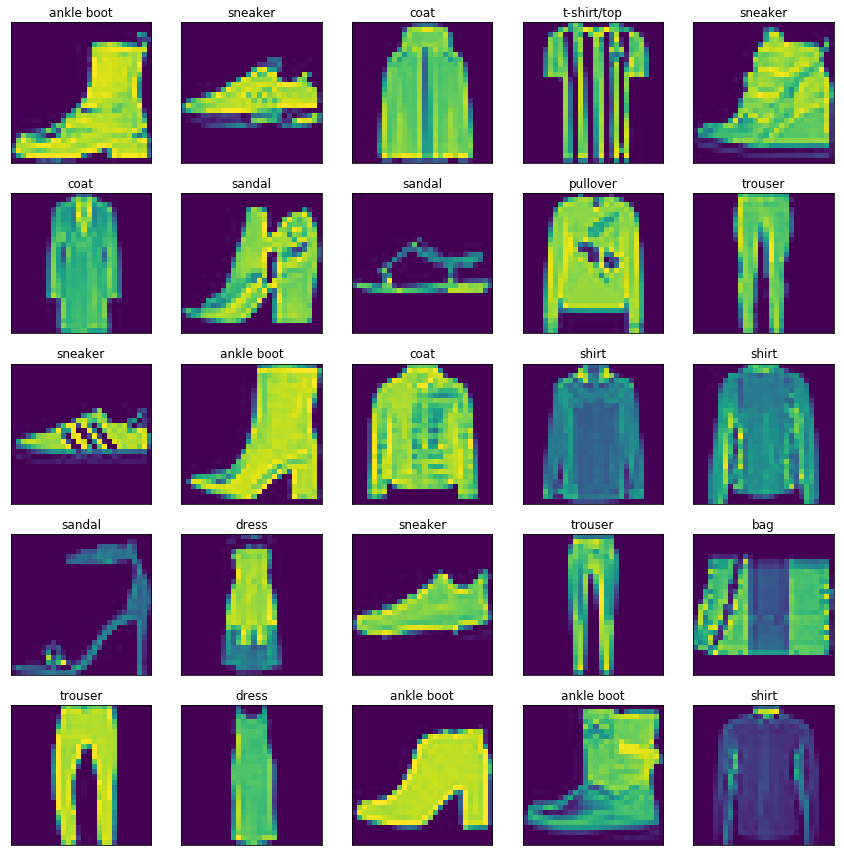

In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
mnist_class_labels = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
show_dataset_examples(x_train, y_train, mnist_class_labels)

Poslední je CIFAR10, který obsahuje 50,000 trénovacích a 10,000 testovacích barevných obrázků z 10 různých tříd: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Obrázky jsou velikosti 32x32 pixelů a každá třída obsahuje přesně 5,000 obrázků. Existuje i verze CIFAR100, která obsahuje 100 výstupních labelů.

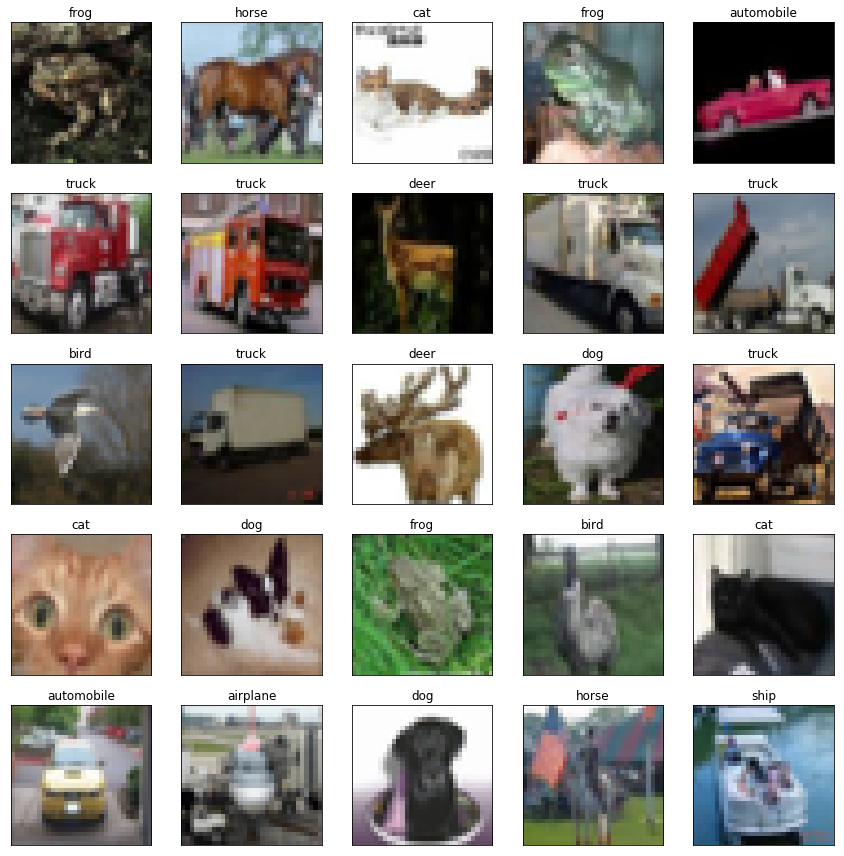

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_dataset_examples(x_train/255, list(map(lambda x: x[0], y_train)), cifar_class_labels)

Nyní se podíváme na samotné konvoluční sítě. Zkusíme si jednu vytvořit a natrénovat ji na klasifikaci číslic z MNISTu. Podíváme-li se na samotný model, vidíme, že se skládá z několika vrstev.
- ```InputLayer``` je normální vrstva určená jako vstup do sítě s jedním parametrem rozměrů vstupu.
- ```Conv2D``` je 2D konvoluční vrstva s parametry počet filtrů (jader) v konvoluci a velikostí 2D konvolučního okénka.
- ```MaxPool2D``` je vrstva pro zmenšení dimenzionality vstupu, která má parametry početkroků a velikost toho, jak se má obrázek zmenšovat v obou dimenzích ((2,2) znamená, že se zmenší v obou rozměrech na polovinu). 
- ```Flatten``` je zploštující vrstva, tedy ze vstupu rozměrů (a,b) udělá výstup o rozměru a*b
- ```Dense``` je jen obyčejná vrstva se zadanou aktivací.
- ```Activation``` přidává k vrstvě aktivaci.

Když nyní rozumíme jednotlivým vrstvám, můžeme se podívat na samotné trénovaní a vyhodnocení modelu.

In [6]:
# nacteme si data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

nb_classes = 10
input_shape = (28, 28, 1)

x_train = x_train.reshape((-1,) + input_shape)/255

# definujeme model
model = tf.keras.models.Sequential([])
model.add(InputLayer(input_shape = input_shape))
model.add(Conv2D(filters=32, kernel_size=(5,5)))
model.add(MaxPool2D(strides=2, pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=5, activation=relu))
model.add(MaxPool2D(strides=2, pool_size=(2, 2)))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=30, activation=relu))
model.add(Dense(units=nb_classes, activation=linear, name='logits'))
model.add(Activation(activation=softmax))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# natrenujeme
model.fit(x_train, y_train, batch_size=128, epochs=2)

Epoch 1/2
60000/60000 [==============================] - 111s 2ms/step - loss: 0.2332 - acc: 0.9317
Epoch 2/2
60000/60000 [==============================] - 107s 2ms/step - loss: 0.0660 - acc: 0.9802


In [7]:
# spocitame accuracy na testovacich datech
x_test = x_test.reshape((-1,) + input_shape)
model.evaluate(x_test/255, y_test)

10000/10000 [==============================] - 7s 744us/step


[0.04804137760153972, 0.9858]

## Matoucí vzory

Na přednášce jste se bavili i o tom, že konvoluční sítě lze docela snadno zmást pomocí tzv. matoucích vzorů. Matoucí vzory můžeme vygenerovat pomocí knihovny cleverhans. Tato knihovna potřebuje tensor aktivací před poslední (softmax) vrstvou. Tu jsme si ale pojmenovali logits, není tedy problém si ji z našeho modelu snadno vzít a zašumět ji. To se dělá tak, že se spočítá derivace chyby podle vstupního obrázku, z toho se udělá signum, pronásobí se epsilonem a přičte se ke vstupu. Epsilon je pole hodnot, které obsahuje různé míry zašumění a můžeme tedy dobře sledovat, jak jeho hodnota zašumělost ovlivňuje.

In [8]:
logits = tf.keras.Model(model.inputs, model.get_layer('logits').output)

attack = cleverhans.attacks.FastGradientMethod(cleverhans.model.CallableModelWrapper(logits, 'logits'), 
                                               sess=tf.keras.backend.get_session())

results = []
eps_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for eps in eps_vals:
    adv_x = attack.generate_np(x_test/255, eps=eps)
    r = model.evaluate(adv_x, y_test)[1]
    results.append(r)

print(results)

[INFO 2020-04-16 16:35:37,266 cleverhans] Constructing new graph for attack FastGradientMethod


10000/10000 [==============================] - 8s 824us/step
[0.9858, 0.8519, 0.4538, 0.1353, 0.041, 0.0188, 0.0138, 0.0127, 0.0121]


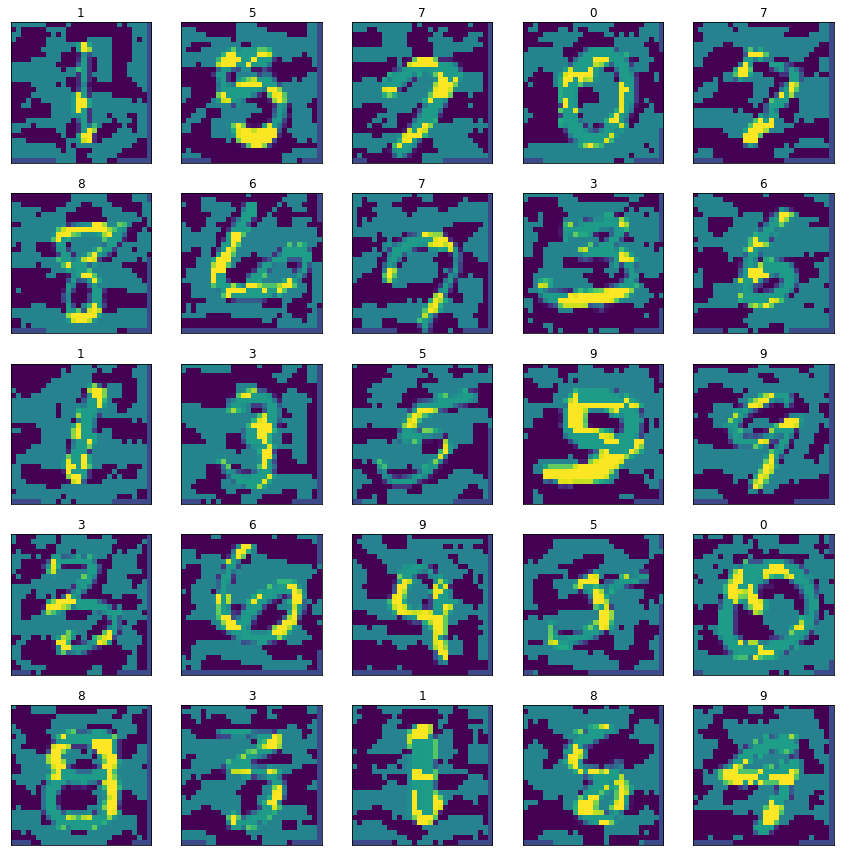

In [12]:
# vykreslime si vzory
mnist_class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
adv_x = adv_x.reshape((-1, 28, 28))
show_dataset_examples(adv_x, y_test, mnist_class_labels)

## Úkol na cvičení

Zkuste si natrénovat zašumnělé vzory i pro CIFAR10 dataset a porovnat, jak moc je těžší, než MNIST. Zároveň si zkuste natrénovat konvoluční síť na Fashion-MNIST a najít nejčastější chyby, kterých se síť při klasifikaci dopouští.

## Image classification

[ImageNet](http://www.image-net.org/) je výzkumý projekt pro vyvíjení velké databáze anatovaných obrázků, tj. obrázků a jejich popis. Na nich se dají trénovat konvoluční sítě například pro image classification task. Bohužel natrénovat takovou síť na takto obrovských datech trvá řádově dny až týdny na grafických kartách. Naštěstí knihovna keras obsahuje některé modely už s předtrénovanými váhami, takže je nemusíme trénovat celé znovu, ale můžeme je používat. Jedním z nich jsou například modely [The Oxford VGG Models](https://www.robots.ox.ac.uk/~vgg/research/very_deep/). My se teď podíváme, jak vypadá jeden z nich, konkrétně VGG16, který je trénovaný na obrázcích z ImageNetu na predikci 1000 různých tříd.

In [20]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Když víme, jaké model obsahuje vrstvy a jak vypadá, zkusíme si načíst nějaký obrázek a nechat model, aby predikoval, co na něm je.

In [24]:
from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

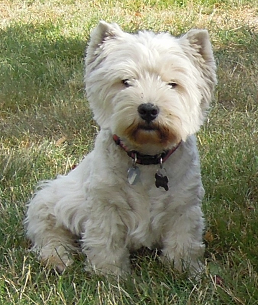

In [25]:
from PIL import Image
Image.open('dog.png')

In [26]:
# nacteme obrazek
image = load_img('dog.png', target_size=(224, 224))
# prevedeme pixely do np array
image = img_to_array(image)
# reshape dat pro model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# pripravime obrazek pro VGG model
image = preprocess_input(image)
# predikce pravdepodobnosti pres vsechny tridy
yhat = model.predict(image)
# prevedem pravdepodobnosti na labely
labels = decode_predictions(yhat)
# vyberem ten s max pravdepodobnosti
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

West_Highland_white_terrier (87.87%)
[[('n02098286', 'West_Highland_white_terrier', 0.8786772), ('n02085936', 'Maltese_dog', 0.03810166), ('n02094114', 'Norfolk_terrier', 0.020698825), ('n02095889', 'Sealyham_terrier', 0.01850271), ('n02097298', 'Scotch_terrier', 0.01045135)]]


Pokud bychom se chtěli podívat na všech 1000 tříd, stačí nám k predikcím přidat parametr, že chceme prvních 1000 labelů.

In [31]:
labels = decode_predictions(yhat, top=1000)
labels = labels[0][:]
labels = [y for (x,y,z) in labels]
# print(labels)

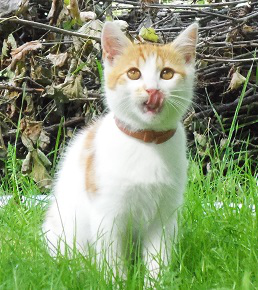

In [20]:
from PIL import Image
Image.open('cat.png')

In [25]:
# nacteme obrazek
image = load_img('cat.png', target_size=(224, 224))
# prevedeme pixely do np array
image = img_to_array(image)
# reshape dat pro model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# pripravime obrazek pro VGG model
image = preprocess_input(image)
# predikce pravdepodobnosti pres vsechny tridy
yhat = model.predict(image)
# prevedem pravdepodobnosti na labely
labels = decode_predictions(yhat)
# vyberem ten s max pravdepodobnosti
label = labels[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))
print(labels)

tiger_cat (60.11%)
[[('n02123159', 'tiger_cat', 0.6011443), ('n02123045', 'tabby', 0.10405338), ('n02124075', 'Egyptian_cat', 0.086554), ('n02441942', 'weasel', 0.037706308), ('n02123597', 'Siamese_cat', 0.022741428)]]


## Domácí úkol

Za domácí úkol budete mít vytvořit si vlastní libovolný dataset na image classfication task, abyste si vyzkoušeli, že vyrábět data není úplně snadné. Dataset by měl mít aspoň 5 různých tříd ke klasifikaci a ke každé nějaké rozumné desítky obrázků.

Až budete mít data, tak si na nich zkuste image classification task. Jak už jsem zmínila výše, trénovat celou konvoluční síť od začátku by bylo početně náročné, proto budete mít za úkol si vybrat 3 z už predtrénovaných modelů například [odsud](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/) a přetrénovat je tak, aby uměly klasifikovat vámi vytvořená data.

Můžete si na vašich datech i zkusit natrénovat podobnou (klidně i stejnou) jednoduchou konvoluční síť, kterou jsme používali před na MNISTu výše a schválně se podívat, jak moc bude špatná oproti těm už předtrénovaným.

Řešení by mělo obsahovat
1. slovní popis vašich dat (jaké máte labely, kolik každý obsahuje obrázků, velikost obrázků, zdůvodnění volby datasetu)
2. váš kód
3. slovní popis a výsledků a porovnání modelů (výsledky mohou být napsané v tabulce)
4. vámi vytvořený předzpracovaný dataset (obrázky by měly být malé, takže by neměl být problém s posláním)

Pár tipů
- bylo by dobré mít u všech tříd stejný počet obrázků
- obrázky bude potřeba převést do nějakého jednotného rozumně malého rozměru (například 128 x 128 pixelů)
- když budete používat předtrénované sítě, tak ty vaše obrázky by měly být stejně velké jako ty, na kterých byla trénovaná ta  síť původně
- zároveň bude potřeba je rozdělit na dvě disjunktní množiny -- trénovací a testovací (trénovací na přetrénovaní modelů a testovací na jejich vyhodnocení)
- model se dá přetrénovat například tak, že si nahradíte poslední nebo několik posledních vrstev vlastními, které budete přetrénovávat podle vašich dat
